# Requirements / Installation

In [ ]:
import csv
import platform
import shutil
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import decomposition, metrics, model_selection, naive_bayes, pipeline
from sklearn.preprocessing import StandardScaler
from os.path import join
import cv2

In [ ]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

1.0.2


In [ ]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1 : Load Data

In [ ]:
from sklearn import preprocessing

In [ ]:
#Path to dataset that contain folder images and labels.csv
dataset_path = "./drive/MyDrive/Output/Output_texture"

df = pd.read_csv(join(dataset_path, "label.csv"))

images = [cv2.imread(join(dataset_path, "TEX_original", filename)) for filename in df['FILE_NAME']]

# images1 = [cv2.imread(join(dataset_path, "transformed_R0", filename+'_R0.jpg')) for filename in df['FILE_NAME']]
# images2 = [cv2.imread(join(dataset_path, "transformed_R1", filename+'_R1.jpg')) for filename in df['FILE_NAME']]
# images3 = [cv2.imread(join(dataset_path, "transformed_R2", filename+'_R2.jpg')) for filename in df['FILE_NAME']]
# images = images1 + images2 + images3

# df1 = df.append(df)
# df = df.append(df1)
labels = df['CATEGORY'].to_numpy() 
y = pd.get_dummies(labels)

In [ ]:
len(y)

120

In [ ]:
np.shape(images)

(120, 128, 128, 3)

In [ ]:
#Label Encoder from string to int
le = preprocessing.LabelEncoder()
le.fit(labels)
y = le.transform(labels)

In [ ]:
#CV2 use RGB we want BGR
images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in images])

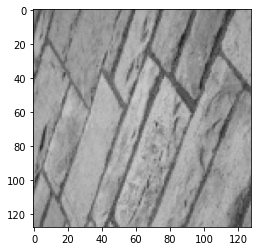

In [ ]:
plt.imshow(images[1])

# Visualize dataset sample

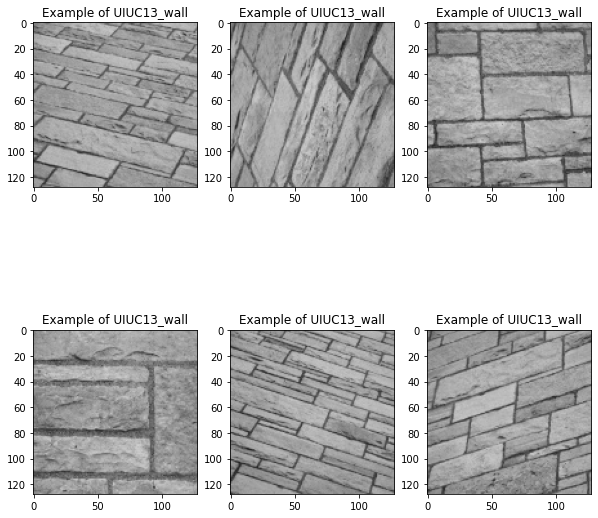

In [ ]:
NUM_TO_SHOW = 6

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

for i in range(NUM_TO_SHOW):
    img = images[i]
    label = labels[i]
    axs[i].set_title(f"Example of {label}")
    axs[i].imshow(img)

plt.show()

# Step 2 : Building a predictive model

In [ ]:
len(images)

120

In [ ]:
xs, ys = {}, {}

#Next line create train and test set and SHUFFLE the data
(
    xs["train"], 
    xs["test-lab"], 
    ys["train"], 
    ys["test-lab"]
) = model_selection.train_test_split(images, y, test_size=0.5, stratify=y, random_state=123)

print(xs["train"].shape, ys["train"].shape)
print(xs["test-lab"].shape, ys["test-lab"].shape)

(60, 128, 128, 3) (60,)
(60, 128, 128, 3) (60,)


# Create Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models, transforms
import torch.nn as nn
import os
import shutil

In [ ]:
#In Pytorch we usually need a Dataset class, quitte easy to understand it just store the data
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.img_labels = labels
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        trsfm  = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        img = self.images[idx].astype(np.uint8)
        img = trsfm(img)
        label = self.img_labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Create Dataloader

Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [ ]:
train_loader = DataLoader(CustomImageDataset(xs["train"],ys["train"]), batch_size=100, shuffle=False)
valid_loader = DataLoader(CustomImageDataset(xs["test-lab"],ys["test-lab"]), batch_size=100, shuffle=False)

# Fix the environment
To make sure the model is deterministic and wont vary from one execution to another

In [ ]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# Prepare GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("GPU detected")
else:
    device = torch.device('cpu')
    print("WARNING : No GPU detected")

GPU detected


In [ ]:
featureExtraction = False #We train only the last layer, previous layer is used for feature extraction
pretained = True # We use a pretrained model
#If pretrained == False then featureExtraction should be false too, there is no point to do feature extr. without pretraining
num_classes = len(np.unique(ys['train'])) #How many classes we have ! 

# Model


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = models.resnet18(pretrained=pretained) #load pre-trained model
if featureExtraction: 
    for param in model.parameters():
        param.requires_grad = False #We freeze all the layer
        
num_ftrs = model.fc.in_features 
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
model.fc = nn.Linear(num_ftrs, num_classes) #modify the last layer according to number of categories we have
model = model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(trainable_params, lr=0.01, momentum=0.9)

In [ ]:
len(train_loader.dataset)

60

In [ ]:
class Trainer:
    '''Class to train our model'''
    def __init__(self, model, criterion, optimizer, train_loader, valid_loader, epochs = 10, verbose = True, save = True):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.epochs = epochs
        self.verbose = verbose
        self.best_valid = 0
        self.save = save
    
    def valid_epoch(self):
        """One epoch of validation -- here Validation == Testing sicne we don't have validation set"""
        self.model.eval()
        nb_images = len(self.valid_loader.dataset)
        with torch.no_grad():
            running_loss = 0.0
            correct = 0
            for i, data in enumerate(self.valid_loader, 0): #iteration through batch 
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels) #Compute the loss
                
                pred = torch.argmax(outputs.cpu(), dim=1) #get the class predictions
                correct += torch.sum(pred == labels.cpu()).item() #count correct answers
                running_loss += loss.item()
            accu = correct/nb_images #compute accuracy
            if self.verbose :
                print(f'Validation : Loss {running_loss/len(self.valid_loader):.3f} Accuracy {accu:.3f}')
               
            if(accu - self.best_valid > 0.0025 and self.save): #we save best model on validation
                self.best_valid = max(self.best_valid, accu)
                self.save_checkpoint()
                

    def train_epoch(self):
        '''One epoch of training'''
        self.model.train()
        nb_images = len(self.train_loader.dataset)
        running_loss = 0.0
        correct = 0
        cmpt = 0
        for i, data in enumerate(self.train_loader, 0): #iteration through batch 
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            pred = torch.argmax(outputs.cpu(), dim=1) #get the class predictions
            correct += torch.sum(pred == labels.cpu()).item() #count correct answers
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
        if self.verbose :
            print(f'Train : Loss {running_loss/len(self.train_loader):.3f} Accuracy {correct/nb_images:.3f}')
        
    def train(self):
        #iterate over the epochs
        for epoch in range(self.epochs):
            if self.verbose :
                print(f"Epoch {epoch} : ")
            self.train_epoch()
            self.valid_epoch()
    
    def save_checkpoint(self):
        #save model
        if self.verbose:
            print("Saving model ...")
        torch.save(model, 'checkpoint-best-epoch.pth')
        
    def getModel(self):
        return self.model
    
    def setModel(self,model):
        self.model = model

In [ ]:
class utils:
    def load_best_model(model):
        #load a saved model
        model = torch.load('checkpoint-best-epoch.pth')
        model.eval()
        return model

    def predict(model, dataloader, device):
        #Make prediction over a dataloader
        model.to('cpu')
        all_preds = torch.tensor([])
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs, labels
            outputs = model(inputs)
            
            outputs = model(inputs) 
            preds = torch.argmax(outputs.cpu(), dim=1) # get preds
            all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis
        return all_preds

In [ ]:
trainer = Trainer(model, criterion, optimizer, train_loader, valid_loader) #create trainer
trainer.train() #train

Epoch 0 : 
Train : Loss 1.271 Accuracy 0.367
Validation : Loss 1.137 Accuracy 0.250
Saving model ...
Epoch 1 : 
Train : Loss 0.470 Accuracy 0.933
Validation : Loss 1.034 Accuracy 0.417
Saving model ...
Epoch 2 : 
Train : Loss 0.202 Accuracy 0.983
Validation : Loss 0.889 Accuracy 0.700
Saving model ...
Epoch 3 : 
Train : Loss 0.092 Accuracy 0.983
Validation : Loss 0.711 Accuracy 0.850
Saving model ...
Epoch 4 : 
Train : Loss 0.038 Accuracy 1.000
Validation : Loss 0.537 Accuracy 0.950
Saving model ...
Epoch 5 : 
Train : Loss 0.016 Accuracy 1.000
Validation : Loss 0.406 Accuracy 0.983
Saving model ...
Epoch 6 : 
Train : Loss 0.007 Accuracy 1.000
Validation : Loss 0.316 Accuracy 0.983
Epoch 7 : 
Train : Loss 0.004 Accuracy 1.000
Validation : Loss 0.251 Accuracy 0.983
Epoch 8 : 
Train : Loss 0.002 Accuracy 1.000
Validation : Loss 0.203 Accuracy 0.983
Epoch 9 : 
Train : Loss 0.002 Accuracy 1.000
Validation : Loss 0.164 Accuracy 0.983


# confusion matrix

In [ ]:
model = utils.load_best_model(model) #load
pred = utils.predict(model, valid_loader, device) #pred over valid_lab
pred = np.array(pred.tolist(),dtype = int)

In [ ]:
true_pred = valid_loader.dataset.img_labels #get the true labels

In [ ]:
data_set = "valid-lab"

cm = metrics.confusion_matrix(true_pred,pred) #compute confusion matrix
plt.imshow(cm, cmap='binary')

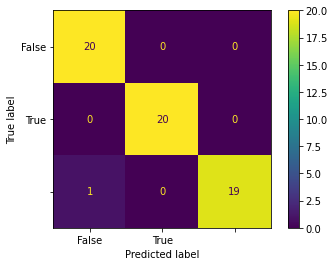

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
model = utils.load_best_model(model) #load model

In [ ]:
pred = utils.predict(model, valid_loader, device) #predict over valid_loader

In [ ]:
accuracy = (20+20+19) / (20*3)
print(accuracy)

In [ ]:
accuracy = (20+20+19) / (20*3)
print(accuracy)

0.9833333333333333


In [ ]:
# %%capture

!git clone https://github.com/ihsaan-ullah/meta-album/blob/master/Factsheets

# /generate_factsheet_results.py

# !mv ihsaan-ullah/meta-album/* 

# !rm -rf neural-style-pt

# !python3 generate_factsheet_results.py

Cloning into 'Factsheets'...
fatal: repository 'https://github.com/ihsaan-ullah/meta-album/blob/master/Factsheets/' not found


In [ ]:
pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


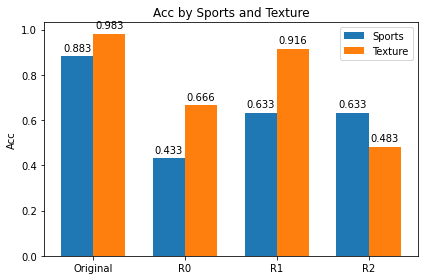

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Original', 'R0', 'R1', 'R2']
SPT_acc = [0.883, 0.433, 0.633, 0.633]
TEX_acc = [0.983, 0.666, 0.916, 0.483]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, SPT_acc, width, label='Sports')
rects2 = ax.bar(x + width/2, TEX_acc, width, label='Texture')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Acc')
ax.set_title('Acc by Sports and Texture')

ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()